## Pauqetes necesarios para este proyecto de ciencia de datos

In [91]:
# Importacion de paquetes que me ayudan a conectar con la API y manejar la imfromación.
import requests # Consultas de API
import pandas as pd # Manejo de based de datos 
import time # Manejo de tiempo 
from datetime import datetime, timedelta # Manejo de fechas 

#---------------------------------------------------------------------------------# 

# Paquetes que me ayudan a trabajar con las series de tiempo y la organización de datos.

import numpy as np # Manejo de arreglos
import matplotlib.pyplot as plt # Graficación
import seaborn as sns # Graficación avanzada

#---------------------------------------------------------------------------------#

from statsmodels.tsa.arima.model import ARIMA # Modelo ARIMA 
from sktime.forecasting.arima import AutoARIMA # Modelo AutoARIMA
from sklearn.metrics import mean_squared_error, r2_score # Evaluaciones de modelos.
from statsmodels.tsa.stattools import adfuller # Prueba de Dickey-Fuller aumentada
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Funciones ACF y PACF
import pmdarima as pm # Funcion autoarima
from sktime.utils.plotting import plot_series

#---------------------------------------------------------------------------------#
import xgboost as xgb # type: ignore Paquete para el modelo XGBoost

#---------------------------------------------------------------------------------#
# Paquetes que me ayudan a trabajar con redes neuronales.
import tensorflow as tf # type: ignore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint  # type: ignore

import warnings
warnings.filterwarnings("ignore")

## 1. Obtención de la información de la API de CoinGecko

In [29]:
years = 1  

bases = {}

# fecha inicial y fecha final (from, to)
fecha_i = int(time.mktime((datetime.today().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=364)).timetuple()))
fecha_f = int(time.mktime(datetime.today().replace(hour=0, minute=0, second=0, microsecond=0).timetuple()))

for j in range(years):
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?precision=2"
    params = {
        'vs_currency':'usd',
        'from': fecha_i,
        'to': fecha_f,
    }
    
    try:
        data = requests.get(url, params=params, timeout=10)  # timeout evita que se quede colgado
        data.raise_for_status()  # lanza error si la API responde con 4xx o 5xx

        result = data.json()
        
        # Validamos que vengan las claves esperadas
        if not all(k in result for k in ['prices','market_caps','total_volumes']):
            raise ValueError("La respuesta de la API no tiene los datos esperados")
        
        # Procesamiento de la respuesta
        fecha = [i[0] for i in result['prices']]
        precio_usd = [i[1] for i in result['prices']]
        market_caps = [i[1] for i in result['market_caps']]
        total_volumes = [i[1] for i in result['total_volumes']]
        
        df = pd.DataFrame({
            "fecha": fecha,
            "precio_usd": precio_usd,
            "market_caps": market_caps,
            "total_volumes": total_volumes
        })
        
        # Ajustamos la columna fecha
        df["fecha"] = [datetime.fromtimestamp(i/1000).strftime("%d-%m-%Y") for i in df["fecha"]]
        
        bases[f"Base_{j}"] = df

        # Actualizamos fechas
        fecha_f = fecha_i
        fecha_i = int(time.mktime((datetime.fromtimestamp(fecha_f) - timedelta(days=365)).timetuple()))
    
    except requests.exceptions.Timeout:
        print(f"⚠️ La petición tardó demasiado en la iteración {j}.")
    except requests.exceptions.RequestException as e:
        print(f"❌ Error de conexión en la iteración {j}: {e}")
    except Exception as e:
        print(f"❌ Error inesperado en la iteración {j}: {e}")

In [30]:
# Obtención de la base de datos final de la consulta 
bdbit = bases['Base_0']
bdbit.head()
bdbit.tail()
# Hasta este punto tenemos la base de datos con la infromación de un año.

,fecha,precio_usd,market_caps,total_volumes
359,25-08-2025,110185.35,2.194454e+12,5.285487e+10
360,26-08-2025,111842.71,2.227026e+12,4.302380e+10
361,27-08-2025,111216.08,2.215255e+12,3.695790e+10
362,28-08-2025,112525.60,2.239423e+12,3.422250e+10
363,29-08-2025,108480.31,2.160279e+12,5.170212e+10


## 2. Preprocesamiento de la información.

In [31]:
# Revisemos si exxisten valores NA
print("valores faltantes por variable \n\n", bdbit.isna().sum(),"\n\nTotal valores duplicados",sep="")
# Con este reusultado vemos que no exiaten valores nulos en la base de datos.

# Revisemos si existen valores duplicados 
bdbit.duplicated().sum()
# Vemos que no existen valores duplicados en la base de datos


valores faltantes por variable 

fecha            0
precio_usd       0
market_caps      0
total_volumes    0
dtype: int64

Total valores duplicados


0

In [32]:
# Tipo de variables de la base de datos.y formato de la fecha.

bdbit["fecha"] = pd.to_datetime(bdbit["fecha"], format="%d-%m-%Y")
print("Tipo de variables de la base de datos\n\n",bdbit.dtypes,"\n\nBase de datos",sep="")

# Poner las fechas como indice y organizar el dataframe por fecha de manera ascendente.

bdbit.set_index("fecha", inplace=True)
bdbit.sort_index(ascending=True,inplace=True)
bdbit.head()

Tipo de variables de la base de datos

fecha            datetime64[ns]
precio_usd              float64
market_caps             float64
total_volumes           float64
dtype: object

Base de datos


,precio_usd,market_caps,total_volumes
fecha,,,
2024-08-31,58960.24,1.164278e+12,1.139909e+10
2024-09-01,57357.72,1.133133e+12,2.546562e+10
2024-09-02,59108.73,1.168410e+12,2.801278e+10
2024-09-03,57504.54,1.137362e+12,2.682998e+10
2024-09-04,57987.85,1.144983e+12,3.755038e+10


Hasta aqui tenemos la base de datos con la información de un año y ordenada por fecha de manera descendente.

**fecha** es la variable de tiempo (índice).  
**precio_usd** es la variable mas importante, ya que es la que nos indica el valor de la criptomoneda en dólares.  
**market_caps** y **total_volumes** variables explicativas (pueden servir para modelos multivariados o análisis   complementarios).



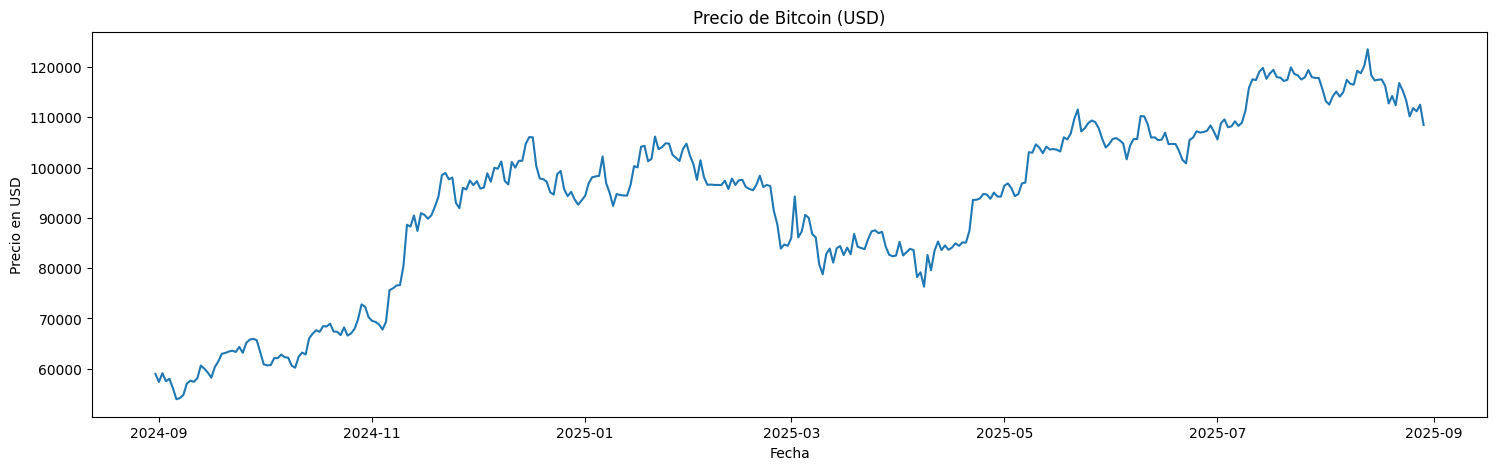

In [33]:
# Visualizacion de la serie de tiempo

plt.figure(figsize=(18,5)) 
plt.plot(bdbit.index, bdbit["precio_usd"])
plt.title("Precio de Bitcoin (USD)")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.show()

Se observa una serie de tiempo creciente, con picos de alta volatilidad y tambien con unas decaidas en ciertos periodos. Esto es característico del mercado de criptomonedas, que tiende a experimentar fluctuaciones significativas en cortos periodos de tiempo. Con este analisis de la base de datos y la visualizacion de la serie de tiempo, podemos preoceder a realizar analisis mas profunfundos y modelos de prediccion sobre una base de datos limpia y ordenada.

## 3. Visualización exploratoria  
### 3.1 Variable de interés: precio_usd

Revisemos nuestra variable de interes **precio_usd** con un histograma y un boxplot para entender su distribución y detectar posibles valores atípicos.

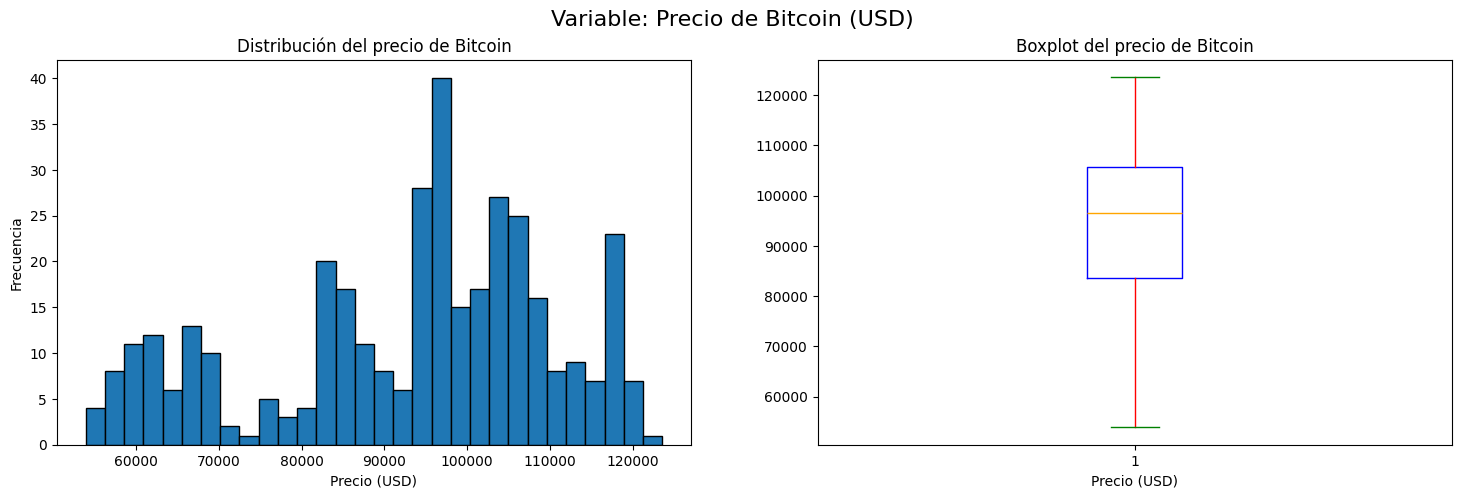

In [34]:
# Visualicemos las distribucion de la variable precio_usd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5)) 
ax1.hist(bdbit["precio_usd"], bins=30, edgecolor="black")
ax1.set_title("Distribución del precio de Bitcoin")
ax1.set_xlabel("Precio (USD)")
ax1.set_ylabel("Frecuencia")

ax2.boxplot(bdbit["precio_usd"], vert=True,boxprops=dict(color='blue'), whiskerprops=dict(color='red'), \
            capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red',\
                                                                                            marker='o'))
ax2.set_title("Boxplot del precio de Bitcoin")
ax2.set_xlabel("Precio (USD)")

fig.suptitle("Variable: Precio de Bitcoin (USD)", fontsize=16)
plt.show()

**Histograma**
* Distribución no normal: El histograma no tiene una forma de campana simétrica. Parece tener varias “concentraciones” de precios (modas), lo que podría reflejar diferentes períodos de alta y baja volatilidad.  
* Sesgo leve a la derecha: Se ve que los valores altos (por encima de 110,000 USD) son menos frecuentes, lo que sugiere una ligera cola hacia la derecha.  
* Volatilidad visible: Las barras están bastante dispersas, lo cual refleja la naturaleza del Bitcoin: precios que fluctúan mucho en lapsos cortos.  

**Boxplot**
* Mediana alta (~95,000 USD): La línea naranja muestra que el valor central está por encima de los 90,000, indicando que la mayoría del tiempo el Bitcoin se mantuvo en un rango relativamente alto.  
* Rango intercuartílico amplio: El “cajón” es bastante grande → mucha dispersión en los precios centrales.  
* Colas largas: Los bigotes llegan hasta casi 123,000 arriba y cerca de 53,000 abajo, confirmando gran variabilidad.  
* Posibles outliers: Aunque no se ven puntos individuales fuera de los bigotes (en esta visualización), es probable que existan valores extremos que se deberian revisar más adelante.

### 3.2 Relaciones entre variables

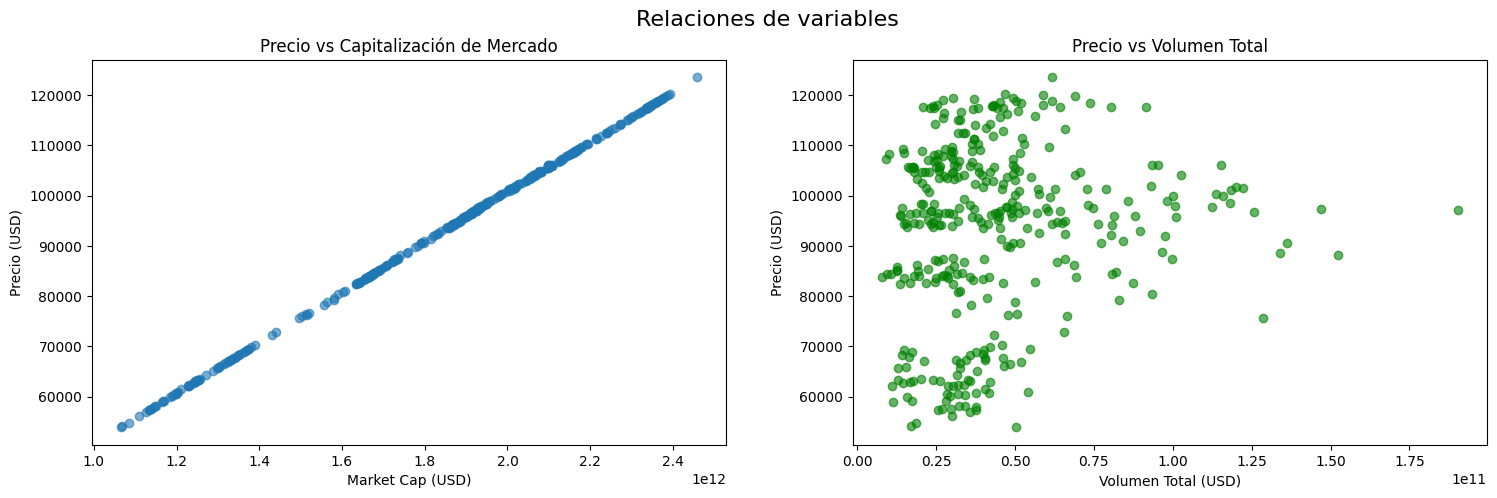

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5)) 
# Precio_usd vs market_caps
ax1.scatter(bdbit["market_caps"], bdbit["precio_usd"], alpha=0.6)
ax1.set_title("Precio vs Capitalización de Mercado")
ax1.set_xlabel("Market Cap (USD)")
ax1.set_ylabel("Precio (USD)")

# Precio_usd vs total_volumes
ax2.scatter(bdbit["total_volumes"], bdbit["precio_usd"], alpha=0.6, color="green")
ax2.set_title("Precio vs Volumen Total")
ax2.set_xlabel("Volumen Total (USD)")
ax2.set_ylabel("Precio (USD)")

fig.suptitle("Relaciones de variables", fontsize=16)
plt.show()

* **Precio vs Capitalización de Mercado**: muestra una relación prácticamente lineal (lo esperado, ya que la capitalización de mercado es precio × oferta en circulación).  
* **Precio vs Volumen Total**: aquí se ve un patrón más disperso, lo que indica que el volumen no tiene una relación tan directa con el precio, pero puede reflejar momentos de alta o baja actividad en el mercado.  

### 3.3 Comportamiento de las variables atraves del tiempo

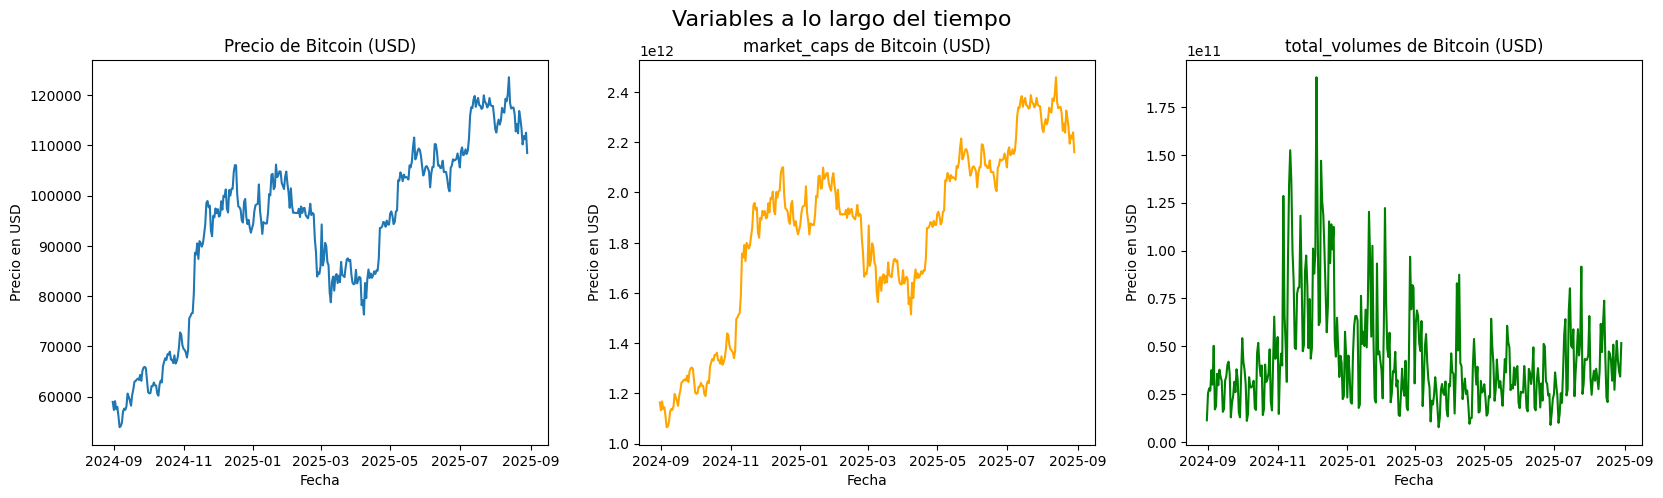

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5)) 

# Graficos 1
ax1.plot(bdbit.index, bdbit["precio_usd"])
ax1.set_title("Precio de Bitcoin (USD)")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Precio en USD")
# Grafico 2
ax2.plot(bdbit.index, bdbit["market_caps"], color="orange")
ax2.set_title("market_caps de Bitcoin (USD)")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio en USD")
# Grafico 3
ax3.plot(bdbit.index, bdbit["total_volumes"], color="green")
ax3.set_title("total_volumes de Bitcoin (USD)")
ax3.set_xlabel("Fecha")
ax3.set_ylabel("Precio en USD")

fig.suptitle("Variables a lo largo del tiempo", fontsize=16)
plt.show()

### 3.4 Correlaciones entre variables


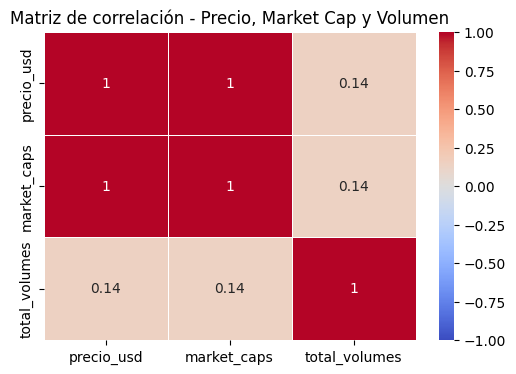

In [37]:
# Dibujar el heatmap
plt.figure(figsize=(6,4))
sns.heatmap(bdbit.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Matriz de correlación - Precio, Market Cap y Volumen", fontsize=12)
plt.show()

* Precio y market cap van de la mano (dependencia casi perfecta).  
* Volumen no está fuertemente correlacionado con precio ni con market cap → es más un indicador de actividad del mercado que de valor.

## 4. Modelado de la serie de tiempo
### 4.1 Modelo ARIMA

Comenzaremos con un modelos ARIMA clasico de las series de tiempo. ARIMA es popular porque modela eficazmente los datos de las series temporales captando tanto los componentes autorregresivos (AR) como los de media móvil (MA), al tiempo que aborda la no estacionariedad mediante la diferenciación (I). Esta combinación hace que los modelos ARIMA sean especialmente flexibles, por lo que se utilizan en sectores muy diferentes, como las finanzas y la predicción meteorológica. 

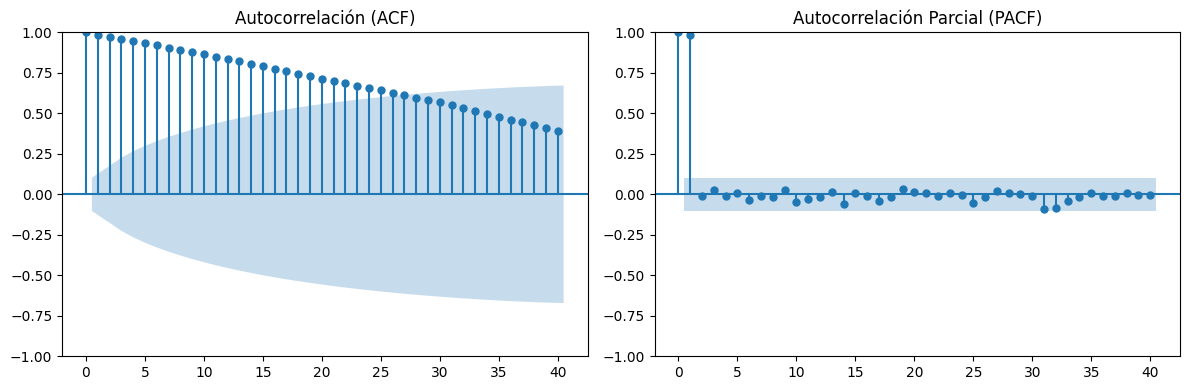

In [38]:
# Funciones ACF y PACF

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas

# Gráfico ACF
plot_acf(bdbit["precio_usd"], lags=40, ax=axes[0])
axes[0].set_title("Autocorrelación (ACF)")

# Gráfico PACF
plot_pacf(bdbit["precio_usd"], lags=40, ax=axes[1])
axes[1].set_title("Autocorrelación Parcial (PACF)")

plt.tight_layout()
plt.show()

In [39]:
traint = int(len(bdbit)*0.9) # 80% porciento de los datos 
bd_train = bdbit[:traint]
bd_test = bdbit[traint:] 

print("Divimos la base de datos en train y test con el 80% y 20% respectivamente \nEs decir: \n\nTrain: "\
      ,bd_train.shape,"\nTest: ",bd_test.shape,"\n",sep="")

modelo_auto = pm.auto_arima(
    bd_train["precio_usd"],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,              # detecta automáticamente el orden de diferenciación
    seasonal=False,      # False porque primero vamos con ARIMA simple
    stepwise=True,       # búsqueda eficiente
    suppress_warnings=True,
    error_action="ignore"
)

print(modelo_auto.summary(),modelo_auto,sep="\n\n")


Divimos la base de datos en train y test con el 80% y 20% respectivamente 
Es decir: 

Train: (327, 3)
Test: (37, 3)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  327
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2960.225
Date:                Sat, 30 Aug 2025   AIC                           5924.449
Time:                        22:28:03   BIC                           5932.023
Sample:                    08-31-2024   HQIC                          5927.472
                         - 07-23-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    183.0332    118.431      1.545      0.122     -49.087     415.153
sigma2      4

He dividido la base de datos en un conjunto de entrenamiento (80%) y prueba (20%) para garantizar una evaluación adecuada del modelo. Posteriormente, utilicé la función **auto_arima** de la librería **pmdarima**, configurada con un rango de búsqueda de parámetros (p y q entre 0 y 5) y con la opción **stepwise=True**, lo que permite encontrar de manera eficiente el mejor modelo sin necesidad de probar todas las combinaciones posibles.

El modelo ajustado fue seleccionado de forma automática y en el resumen obtenido se muestran los parámetros estimados, los valores de significancia de los coeficientes y los criterios de información (AIC y BIC) que respaldan la elección realizada. Este resumen permite identificar cuál fue la mejor configuración del modelo ARIMA simple encontrada en los datos y proporciona una primera evidencia de su ajuste.

In [40]:
# Predicciones sobre el conjunto de prueba

bd_predic = modelo_auto.predict(n_periods=len(bd_test))
bd_predic

2025-07-24    118812.093190
2025-07-25    118995.126380
2025-07-26    119178.159571
2025-07-27    119361.192761
2025-07-28    119544.225951
2025-07-29    119727.259141
2025-07-30    119910.292331
2025-07-31    120093.325521
2025-08-01    120276.358712
2025-08-02    120459.391902
2025-08-03    120642.425092
2025-08-04    120825.458282
2025-08-05    121008.491472
2025-08-06    121191.524663
2025-08-07    121374.557853
2025-08-08    121557.591043
2025-08-09    121740.624233
2025-08-10    121923.657423
2025-08-11    122106.690613
2025-08-12    122289.723804
2025-08-13    122472.756994
2025-08-14    122655.790184
2025-08-15    122838.823374
2025-08-16    123021.856564
2025-08-17    123204.889755
2025-08-18    123387.922945
2025-08-19    123570.956135
2025-08-20    123753.989325
2025-08-21    123937.022515
2025-08-22    124120.055706
2025-08-23    124303.088896
2025-08-24    124486.122086
2025-08-25    124669.155276
2025-08-26    124852.188466
2025-08-27    125035.221656
2025-08-28    125218

In [41]:
len(bdbit.index[len(bd_test):])
len(bdbit.index[:len(bd_train)])

len(bd_test)
bdbit.index

DatetimeIndex(['2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03',
               '2024-09-04', '2024-09-05', '2024-09-06', '2024-09-07',
               '2024-09-08', '2024-09-09',
               ...
               '2025-08-20', '2025-08-21', '2025-08-22', '2025-08-23',
               '2025-08-24', '2025-08-25', '2025-08-26', '2025-08-27',
               '2025-08-28', '2025-08-29'],
              dtype='datetime64[ns]', name='fecha', length=364, freq=None)

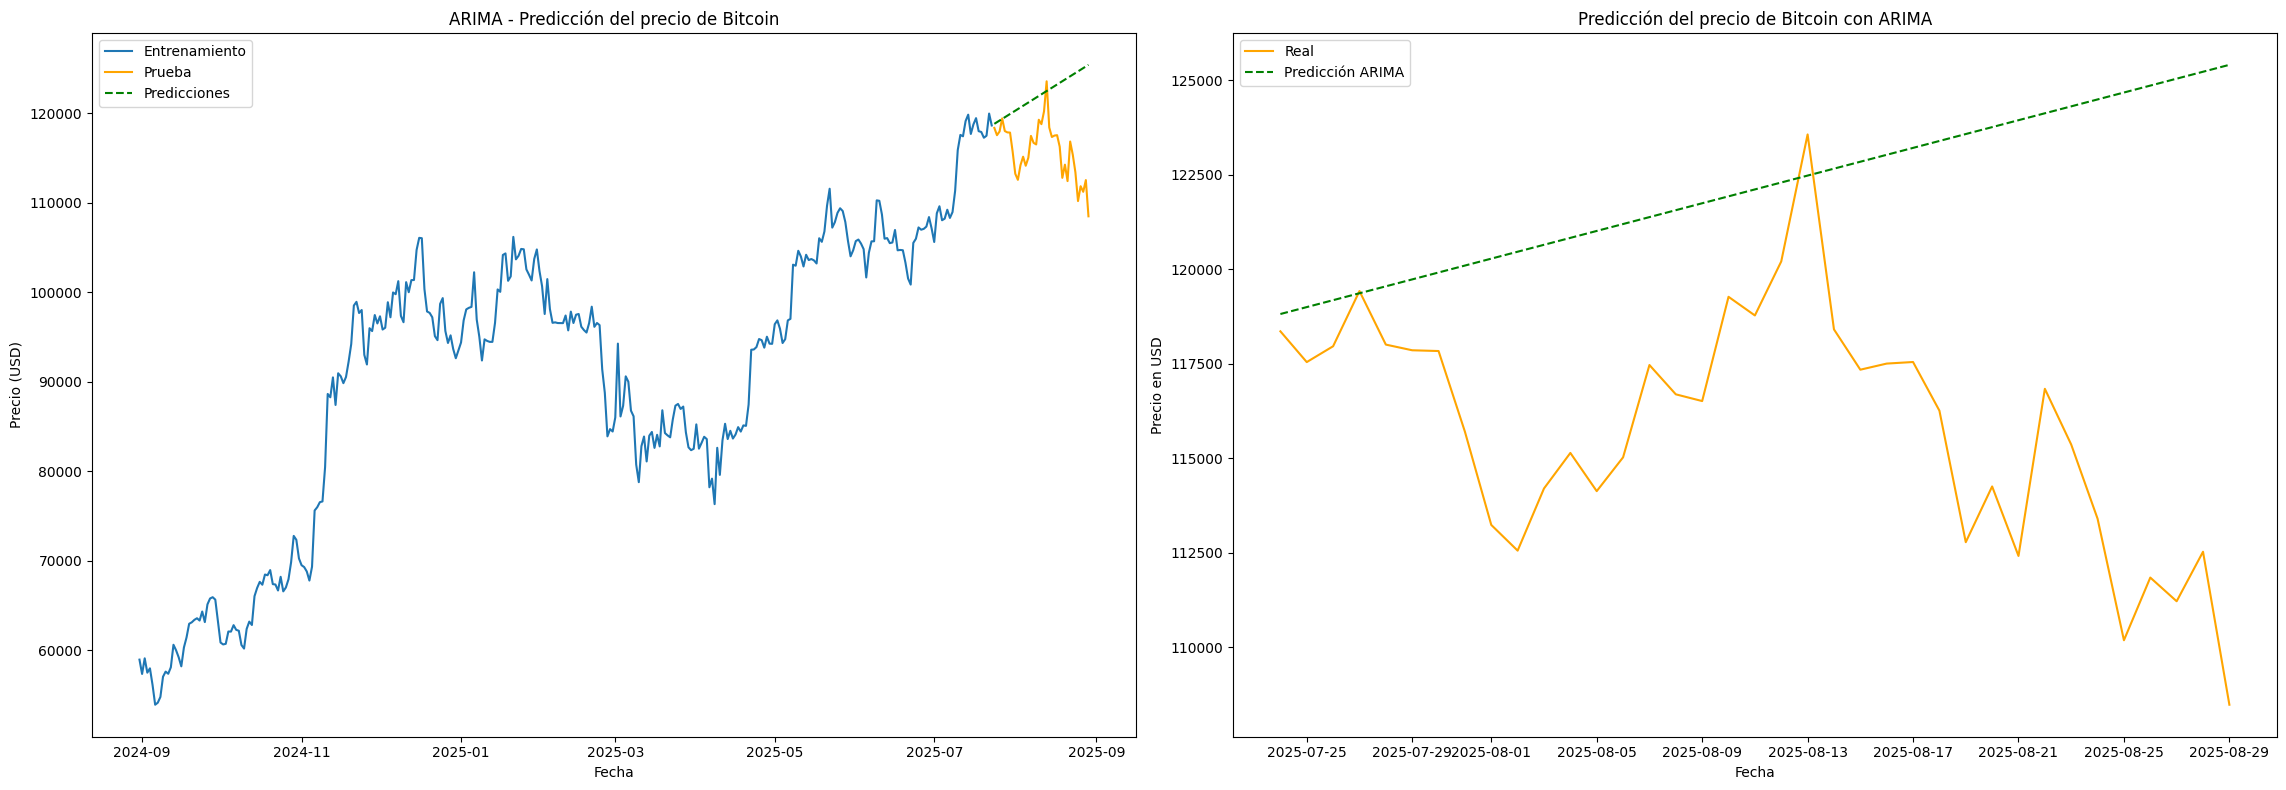

In [42]:
# Visualización de resultados

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8))
# Gráfico 1
ax1.plot(bd_train.index, bd_train["precio_usd"], label="Entrenamiento")
ax1.plot(bd_test.index, bd_test["precio_usd"], label="Prueba", color="orange")
ax1.plot(bd_test.index, bd_predic, label="Predicciones", color="green", linestyle="--")
ax1.set_title("ARIMA - Predicción del precio de Bitcoin")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Precio (USD)")
ax1.legend()

# Gráfico 2
ax2.plot(bd_test.index, bd_test["precio_usd"], label="Real", color="orange")
ax2.plot(bd_test.index, bd_predic, label="Predicción ARIMA", color="green", linestyle="--")
ax2.set_title("Predicción del precio de Bitcoin con ARIMA")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio en USD")
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Hacer predicción directamente en sktime
fh = list(range(1, len(bd_test)+1))
y_pred = modelo_auto.predict(fh=fh)

# Graficar
fig, ax = plot_series(bd_train["precio_usd"], bd_test["precio_usd"], y_pred,
                      labels=["Train", "Test", "Predicción"])

# Personalización
ax.set_title("Predicción del precio de Bitcoin con ARIMA", fontsize=14)
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Precio en USD", fontsize=12)
plt.show()

El modelo ARIMA muestra un buen ajuste sobre los datos de entrenamiento, siguiendo la tendencia general sin mayores problemas. Sin embargo, al compararlo con la serie de prueba, se observa que no logra capturar la fuerte volatilidad característica del Bitcoin: las predicciones aparecen suavizadas, con un rezago evidente frente a los movimientos bruscos. Esto provoca que el modelo subestime las caídas rápidas y no alcance a recuperar los niveles altos cuando el precio se recupera. En conclusión, ARIMA resulta útil como modelo de referencia para tendencias suaves, pero no es adecuado para series altamente volátiles como las criptomonedas, ya que tiende a aplanar las predicciones y pierde la dinámica real de los datos.

### 4.2 Modelo XGboost

XGBoost (Extreme Gradient Boosting) es una implementación del algoritmo Gradient Boosting (GBM) para tareas de aprendizaje supervisado (regresión y clasificación). El algoritmo XGBoost utiliza ensambles de árboles de decisión (Tree ensembles), combinando multiples modelos “débiles” para generar un modelo predictivo con mejor desempeño. La técnica de boosting es usada como método de ensamble y gradient descent para optimizar el proceso. XGBoost nos ofrece gran flexibilidad en cuanto al ajuste de hiperparámentros para controlar la complejidad y evitar el sobreentrenamiento (overfitting). Además, proporciona soporte para trabajar con valores faltantes y variables categóricas.

In [44]:
X = bdbit.drop(columns=["precio_usd"]) # Eliminamos la variable objetivo del conjunto de características
y = bdbit["precio_usd"] # Variable objetivo

# Dividir Train/Test

split = int(len(X)*0.9)
X_train, X_test = X.iloc[:split], X.iloc[split:] # Dividir en 80% train y 20% test
y_train, y_test = y.iloc[:split], y.iloc[split:] # Dividir en 80% train y 20% test

# Entrenar el modelo 
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
        #   eval_metric="rmse",
          verbose=50)

y_predXG = model.predict(X_test)


[0]	validation_0-rmse:15640.97998	validation_1-rmse:24394.18201
[50]	validation_0-rmse:4681.91216	validation_1-rmse:10522.78750
[100]	validation_0-rmse:2080.27694	validation_1-rmse:6488.49441
[150]	validation_0-rmse:1390.64170	validation_1-rmse:5532.39129
[200]	validation_0-rmse:1037.91685	validation_1-rmse:5069.85255
[250]	validation_0-rmse:842.09376	validation_1-rmse:4856.37373
[300]	validation_0-rmse:708.54185	validation_1-rmse:4714.05347
[350]	validation_0-rmse:611.94853	validation_1-rmse:4645.50244
[400]	validation_0-rmse:543.43096	validation_1-rmse:4603.22142
[450]	validation_0-rmse:485.77694	validation_1-rmse:4591.57693
[500]	validation_0-rmse:442.31632	validation_1-rmse:4572.28437
[550]	validation_0-rmse:404.97113	validation_1-rmse:4543.50716
[600]	validation_0-rmse:371.93086	validation_1-rmse:4518.78590
[650]	validation_0-rmse:339.11844	validation_1-rmse:4493.77971
[700]	validation_0-rmse:314.78729	validation_1-rmse:4473.10426
[750]	validation_0-rmse:290.29830	validation_1-rms

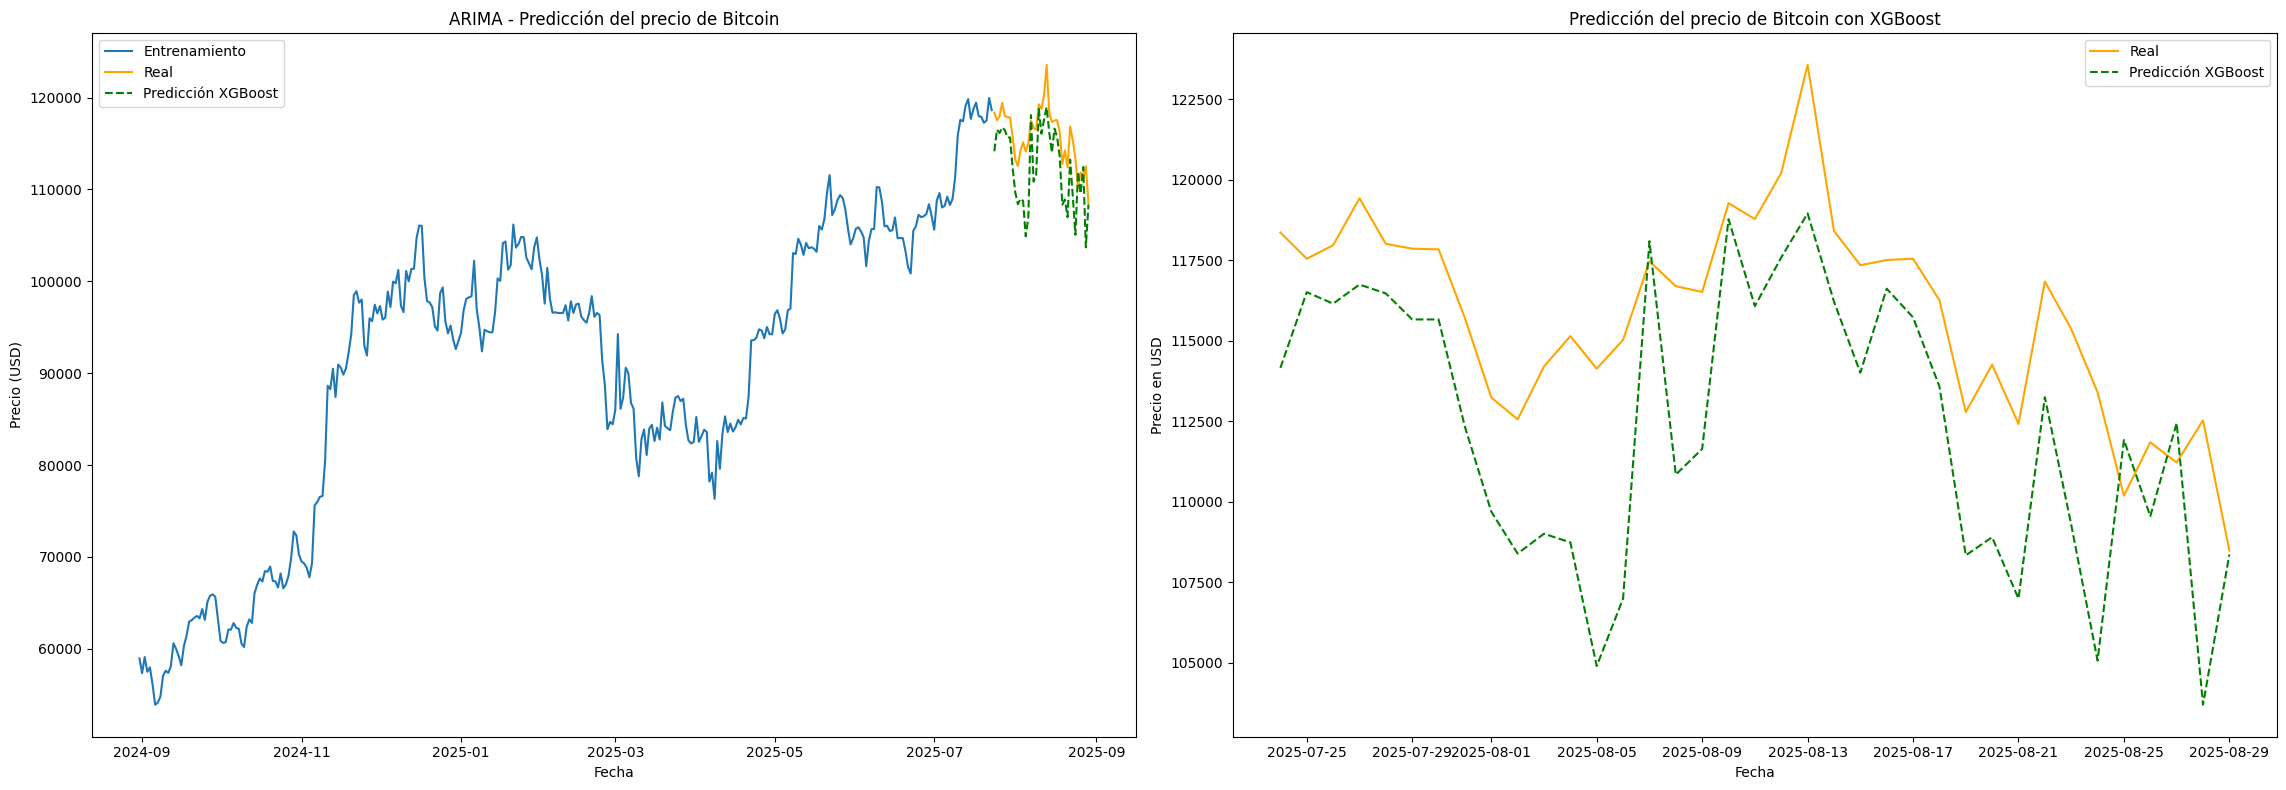

In [ ]:
# Visualizacion del modelo 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8)) 
 
# Gráfico 1
ax1.plot(bd_train.index, bd_train["precio_usd"], label="Entrenamiento")
ax1.plot(y_test.index, y_test, label="Real", color="orange")
ax1.plot(y_test.index, y_predXG, label="Predicción XGBoost", color="green", linestyle="--")
ax1.set_title("ARIMA - Predicción del precio de Bitcoin")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Precio (USD)")  
ax1.legend()

# Gráfico 2
ax2.plot(y_test.index, y_test, label="Real", color="orange")
ax2.plot(y_test.index, y_predXG, label="Predicción XGBoost", color="green", linestyle="--")
ax2.set_title("Predicción del precio de Bitcoin con XGBoost")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio en USD")
ax2.legend()
plt.tight_layout()

plt.show()

El modelo XGBoost predice mucho mejor que ARIMA. Se observa que las curvas de la serie real y las predicciones están bastante alineadas, lo que indica un buen ajuste. El modelo logra seguir las tendencias y movimientos locales del precio de Bitcoin, aunque todavía suaviza un poco los picos más altos y los mínimos más bajos. Aun así, el error general es menor que con ARIMA, lo que sugiere mejores métricas de desempeño. Para mejorar aún más, sería útil afinar los hiperparámetros y agregar más variables explicativas. En conjunto, XGBoost demuestra ser una opción más sólida y precisa para este tipo de serie temporal.

### 4.3  Long Short-Term Memory (LSTM/Deep Learning)





In [ ]:
# =======================================
# 1. Preparar datos
# =======================================
# Supongamos que tu serie es bd['price']
serie = bdbit["precio_usd"].values.reshape(-1,1)

# Escalamos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0,1))
serie_scaled = scaler.fit_transform(serie)

# Función para crear ventanas de tiempo
def crear_ventanas(data, pasos=60):
    X, y = [], []
    for i in range(pasos, len(data)):
        X.append(data[i-pasos:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Creamos ventanas (ej: 60 días atrás para predecir el siguiente)
pasos = 60
X1, y1 = crear_ventanas(serie_scaled, pasos)

# Reshape a [samples, time_steps, features]
X1 = X1.reshape((X1.shape[0], X1.shape[1], 1))

# División train/test
train_size = int(len(X1)*0.9)
X_train1, X_test1 = X1[:train_size], X1[train_size:]
y_train1, y_test1 = y1[:train_size], y1[train_size:]


# =======================================
# 2. Definir modelo LSTM
# =======================================
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train1.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Predicción de un solo valor

# model.compile(optimizer='adam', loss='mean_squared_error')



# EarlyStopping para evitar sobreajuste
# es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Entrenar modelo
# history = model.fit(
#     X_train1, y_train1, 
#     validation_data=(X_test1, y_test1),
#     epochs=50, batch_size=32, 
#     callbacks=[es], verbose=1
# )

# =======================================
# 1. Modelo LSTM mejorado
# =======================================
model = Sequential()

# Capa Bidirectional LSTM más profunda
model.add(Bidirectional(
    LSTM(units=128, return_sequences=True, recurrent_dropout=0.2), 
    input_shape=(X_train1.shape[1], 1)
))
model.add(Dropout(0.2))

# Segunda capa LSTM con regularización
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2))
model.add(Dropout(0.2))

# Tercera capa LSTM más pequeña para compactar
model.add(LSTM(units=64, recurrent_dropout=0.1))
model.add(Dropout(0.15))

# Capa densa intermedia para mayor capacidad
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

# Capa de salida
model.add(Dense(1))

# Compilación con un optimizador más robusto
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error"
)

# =======================================
# 2. Callbacks mejorados
# =======================================
es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6)
mc = ModelCheckpoint("best_lstm_model.h5", monitor="val_loss", save_best_only=True)

# =======================================
# 3. Entrenamiento
# =======================================
history = model.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=150, batch_size=32,
    callbacks=[es, rlr, mc],
    verbose=1
)


# =======================================
# 3. Predicciones
# =======================================
y_pred1 = model.predict(X_test1)
y_pred1 = scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test1.reshape(-1,1))

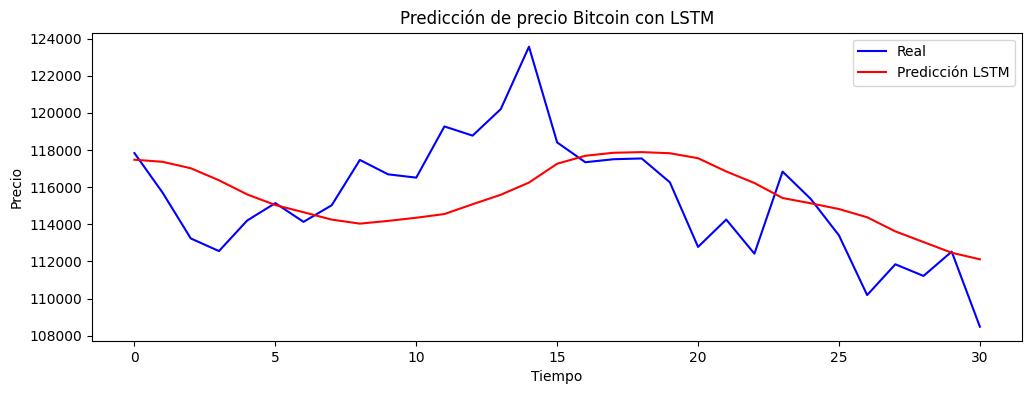

In [93]:
# =======================================
# 4. Visualización
# =======================================
plt.figure(figsize=(12,4))
plt.plot(y_test_rescaled, label="Real", color="blue")
plt.plot(y_pred1, label="Predicción LSTM", color="red")
plt.title("Predicción de precio Bitcoin con LSTM")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()

plt.show()


**Conclusión**:  
Tras la comparación visual de las predicciones generadas por los diferentes modelos, se observa que el desempeño del LSTM y de los modelos lineales resulta limitado, ya que tienden a suavizar la serie y no logran reproducir adecuadamente las variaciones abruptas del precio. En contraste, el modelo XGBoost evidencia una mayor capacidad para capturar tanto la tendencia general como los picos y caídas presentes en la serie temporal. Esto sugiere que, en este contexto, XGBoost constituye la alternativa más adecuada para representar el comportamiento del precio de Bitcoin, dado que refleja de manera más realista la dinámica y volatilidad características del mercado.